In [2]:
from bnn.data import category_examples
from bnn.util import open_pickle_file
from bnn.predict import predict_on_data

from keras import backend as K
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math
from tensorflow.contrib import distributions
from scipy.misc import logsumexp

Using TensorFlow backend.


In [192]:
# Bayesian categorical cross entropy.
# N data points, C classes, T monte carlo simulations
# true - true values. Shape: (N, C)
# pred_var - predicted logit values and variance. Shape: (N, C + 1)
# returns - loss (N,)
def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(true, pred_var):
    # shape: (N,1)
    std = K.sqrt(pred_var[:, num_classes:])
    # shape: (N,)
    variance = pred_var[:, num_classes]
    variance_depressor = K.exp(variance) - K.ones_like(variance)
    # shape: (N, C)
    pred = pred_var[:, 0:num_classes]
    # shape: (N,)
    undistorted_loss = K.categorical_crossentropy(pred, true, from_logits=True)
    # shape: (T,)
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy(true, pred, dist, undistorted_loss, num_classes), iterable, name='monte_carlo_results')
    
    variance_loss = K.mean(monte_carlo_results, axis=0) * undistorted_loss
    
    return variance_loss + undistorted_loss + variance_depressor
  
  return bayesian_categorical_crossentropy_internal

# for a single monte carlo simulation, 
#   calculate categorical_crossentropy of 
#   predicted logit values plus gaussian 
#   noise vs true values.
# true - true values. Shape: (N, C)
# pred - predicted logit values. Shape: (N, C)
# dist - normal distribution to sample from. Shape: (N, C)
# undistorted_loss - the crossentropy loss without variance distortion. Shape: (N,)
# num_classes - the number of classes. C
# returns - total differences for all classes (N,)
def gaussian_categorical_crossentropy(true, pred, dist, undistorted_loss, num_classes):
  def map_fn(i):
    std_samples = K.transpose(dist.sample(num_classes))
    distorted_loss = K.categorical_crossentropy(pred + std_samples, true, from_logits=True)
    diff = undistorted_loss - distorted_loss
    return -K.elu(diff)
  return map_fn

In [184]:
def loss_matrix(min_x=-4, max_x=4, min_y=0, max_y=100):
  loss_fn = bayesian_categorical_crossentropy(10000, 2)

  correct_val = 1.0

  X = [1.0 + x/2 for x in range(min_x, max_x+1)]
  Y = [0.000000001 + y/50 for y in range(min_y, max_y+1)]
  X, Y = np.meshgrid(X, Y)
  predictions = []

  for i in range(len(X)):
    for j in range(len(X[0])):
      y = Y[i][j]
      x = X[i][j]
      predictions.append([correct_val, x, y])

  pred_count = len(predictions)
  true = K.variable(np.hstack((np.ones((pred_count, 1)), np.zeros((pred_count, 1)))))
  pred_var = K.variable(np.array(predictions))
  Z = K.eval(loss_fn(true, pred_var))
  Z = np.reshape(Z, (len(X), len(X[0])))
  return (X, Y, Z)

In [193]:
X, Y, Z = loss_matrix(min_x=-20, max_x=20, max_y=150)
# X, Y, Z = loss_matrix(min_x=100, max_x=110, min_y=0, max_y=400)

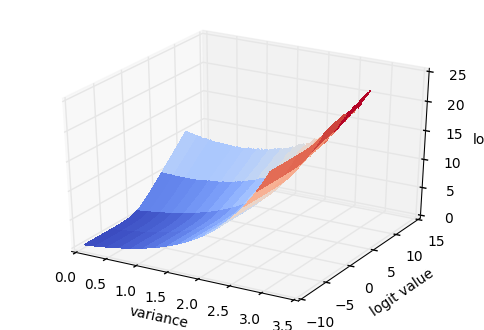

In [194]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('variance')
ax.set_ylabel('logit value')
ax.set_zlabel('loss')
plt.show()

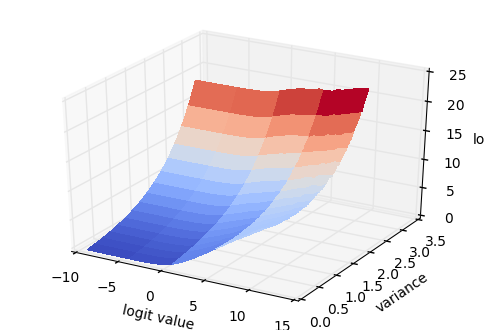

In [195]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('logit value')
ax.set_ylabel('variance')
ax.set_zlabel('loss')
plt.show()

In [196]:
print("Size:", X.shape)
print("Max variance. min idx:", np.argmin(Z[-1,:]), "logit that minimizes loss:", X[-1, np.argmin(Z[-1,:])])
print("Min variance. min idx", np.argmin(Z[0,:]), "logit that minimizes loss:", X[0,np.argmin(Z[0,:])])
print("Max logit value. min idx:", np.argmin(Z[:,-1]), "variance that minimizes loss:", Y[np.argmin(Z[:,-1]), -1])
print("Min logit. min idx:", np.argmin(Z[:,0]), "varaince that minimizes loss:", Y[np.argmin(Z[:,0]), 0])

Size: (151, 41)
Max variance. min idx: 0 logit that minimizes loss: -9.0
Min variance. min idx 0 logit that minimizes loss: -9.0
Max logit value. min idx: 47 variance that minimizes loss: 0.940000001
Min logit. min idx: 0 varaince that minimizes loss: 1e-09


In [197]:
for i in range(len(X[0])):
  min_var_idx = np.argmin(Z[:,i])
  print('idx:', i, 'logit value:', X[0,i], 'variance:', Y[min_var_idx,i], 'loss:', Z[min_var_idx,i], "fc'-fc:", X[0,i]-1.0)

idx: 0 logit value: -9.0 variance: 1e-09 loss: 4.54177e-05 fc'-fc: -10.0
idx: 1 logit value: -8.5 variance: 1e-09 loss: 7.48606e-05 fc'-fc: -9.5
idx: 2 logit value: -8.0 variance: 1e-09 loss: 0.000123374 fc'-fc: -9.0
idx: 3 logit value: -7.5 variance: 1e-09 loss: 0.00020347 fc'-fc: -8.5
idx: 4 logit value: -7.0 variance: 1e-09 loss: 0.000335399 fc'-fc: -8.0
idx: 5 logit value: -6.5 variance: 1e-09 loss: 0.000552978 fc'-fc: -7.5
idx: 6 logit value: -6.0 variance: 1e-09 loss: 0.000911416 fc'-fc: -7.0
idx: 7 logit value: -5.5 variance: 1e-09 loss: 0.00150234 fc'-fc: -6.5
idx: 8 logit value: -5.0 variance: 1e-09 loss: 0.00247565 fc'-fc: -6.0
idx: 9 logit value: -4.5 variance: 1e-09 loss: 0.0040784 fc'-fc: -5.5
idx: 10 logit value: -4.0 variance: 1e-09 loss: 0.00671535 fc'-fc: -5.0
idx: 11 logit value: -3.5 variance: 1e-09 loss: 0.0110477 fc'-fc: -4.5
idx: 12 logit value: -3.0 variance: 1e-09 loss: 0.01815 fc'-fc: -4.0
idx: 13 logit value: -2.5 variance: 1e-09 loss: 0.0297504 fc'-fc: -3.5
i

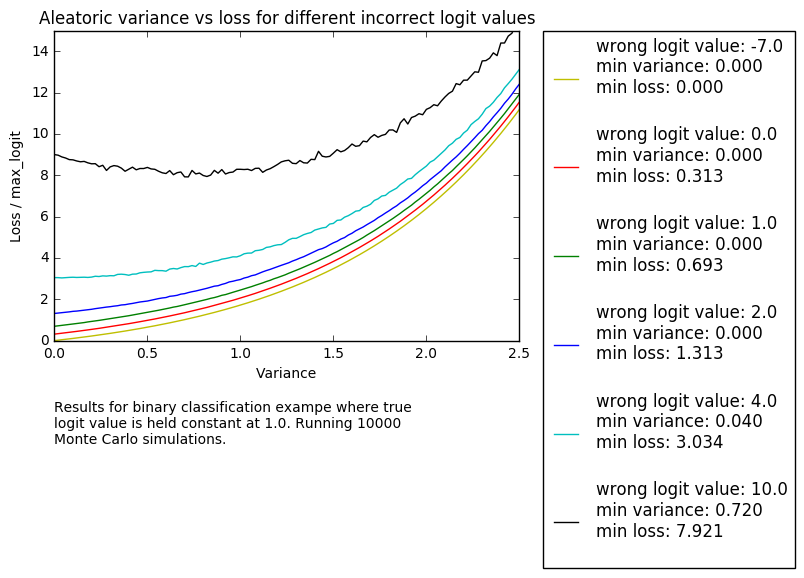

In [198]:
def plot_variance_loss(idxs):
  colors = ['y', 'r', 'g', 'b', 'c', 'k']
  lines = []
  losses = []
  for i in range(len(idxs)):
    idx = idxs[i]
    min_var_idx = np.argmin(Z[:,idx])
    min_var = Y[min_var_idx,idx]
    min_loss = Z[min_var_idx,idx]
    loss = Z[:,idx]
    losses.append(loss)
    legend_label = 'wrong logit value: {0:}\nmin variance: {1:.3f}\nmin loss: {2:.3f}\n'.format(X[0,idx], min_var, min_loss)
    line, = plt.plot(Y[:,idx], loss, colors[i], label=legend_label)
    lines.append(line)
    
  plt.xlabel('Variance')
  plt.ylabel('Loss / max_logit')
  plt.axis([0, 2.5, 0., 15.0])
  plt.legend(handles=lines, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.title('Aleatoric variance vs loss for different incorrect logit values')
  plt.text(0, -5, 'Results for binary classification exampe where true\nlogit value is held constant at 1.0. Running 10000\nMonte Carlo simulations.')
  plt.savefig('blog_images/aleatoric_variance_loss_function_analysis', bbox_inches='tight')
  plt.show()


plot_variance_loss([4, 18, 20, 22, 26, 38])

In [244]:
def bayesian_categorical_crossentropy_values(T, num_classes):
  def bayesian_categorical_crossentropy_internal(true, pred_var):
    # shape: [N, C]
    std = K.sqrt(pred_var[:, num_classes:])
    pred = pred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy_values(true, pred, dist, num_classes), iterable, name='monte_carlo_results')
    return K.mean(monte_carlo_results, axis=0)
  return bayesian_categorical_crossentropy_internal

# for a single monte carlo simulation, 
#   calculate categorical_crossentropy of 
#   predicted logit values plus gaussian 
#   noise vs true values.
# true - true values. Shape: (N, C)
# pred - predicted logit values. Shape: (N, C)
# dist - normal distribution to sample from. Shape: (N, C)
# returns - total differences for all classes (N)
def gaussian_categorical_crossentropy_values(true, pred, dist, num_classes):
  def map_fn(i):
    std_samples = K.transpose(dist.sample(num_classes))
    cross_entropy = K.categorical_crossentropy(pred + std_samples, true, from_logits=True)
    return cross_entropy
  return map_fn

In [245]:
inputs = np.array([[0.0, i, 0.0] for i in range(-5, 6)])
true = np.dstack([np.ones(len(inputs)), np.zeros(len(inputs))])
baysean_losses = K.eval(bayesian_categorical_crossentropy_values(1, 2)(K.variable(true), K.variable(inputs)))

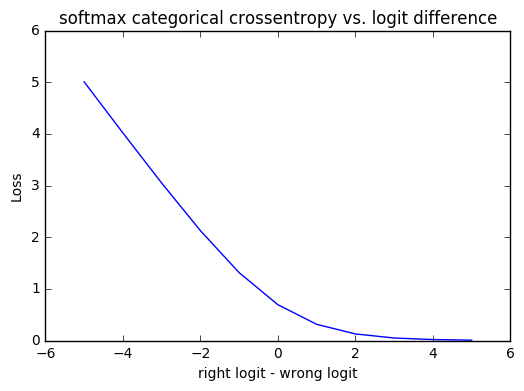

In [250]:
import matplotlib.pyplot as plt
plt.plot([-i for i in range(-5, 6)], baysean_losses[0])
plt.xlabel('right logit - wrong logit')
plt.ylabel('Loss')
plt.title('softmax categorical crossentropy vs. logit difference')
plt.savefig('blog_images/softmax_categorical_crossentropy_v_logit_difference', bbox_inches='tight')
plt.show()

There are two distinct sections to this graph. When the logit different is less than -e the line is linear. When it is greater than this line the slope is non-linear.

In [253]:
def bayesian_categorical_crossentropy_monte_carlo(T, num_classes):
  def bayesian_categorical_crossentropy_internal(true, pred_var):
    # shape: [N, C]
    std = K.sqrt(pred_var[:, num_classes:])
    pred = pred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy_monte_carlo(true, pred, dist, num_classes), iterable, name='monte_carlo_results')
    return monte_carlo_results
  return bayesian_categorical_crossentropy_internal

# for a single monte carlo simulation, 
#   calculate categorical_crossentropy of 
#   predicted logit values plus gaussian 
#   noise vs true values.
# true - true values. Shape: (N, C)
# pred - predicted logit values. Shape: (N, C)
# dist - normal distribution to sample from. Shape: (N, C)
# returns - total differences for all classes (N)
def gaussian_categorical_crossentropy_monte_carlo(true, pred, dist, num_classes):
  orig_loss = K.categorical_crossentropy(pred, true, from_logits=True)
  def map_fn(i):
    std_samples = K.transpose(dist.sample(num_classes))
    cross_entropy = K.categorical_crossentropy(pred + std_samples, true, from_logits=True)
    return orig_loss - cross_entropy
  return map_fn

In [310]:
inputs = np.array([[0.0, 10.0, 1.0], [10.0, 0.0, 1.0]])
true = np.dstack([np.ones(len(inputs)), np.zeros(len(inputs))])
baysean_monte_carlo = K.eval(bayesian_categorical_crossentropy_monte_carlo(1000, 2)(K.variable(true), K.variable(inputs)))
wrong_logit_loss = baysean_monte_carlo[:,0,0]
right_logit_loss = baysean_monte_carlo[:,0,1]

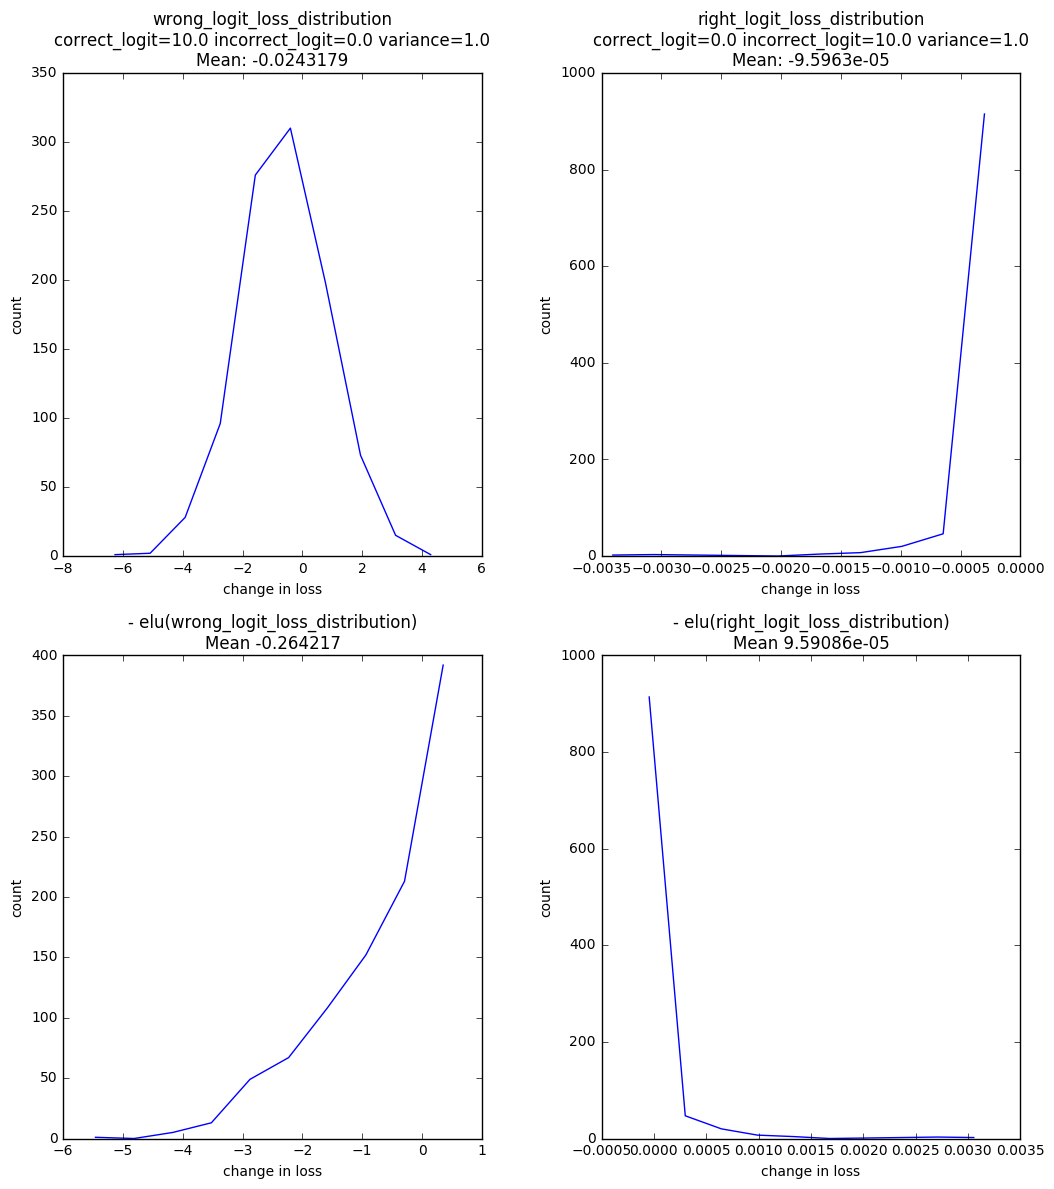

In [311]:
f, ((a1, a2), (a3, a4)) = plt.subplots(2, 2, figsize=(5, 5))
f.tight_layout()

y, bins = np.histogram(right_logit_loss)
a2.plot(bins[:-1], y)
a2.set_ylabel('count')
a2.set_xlabel('change in loss')
a2.set_title('right_logit_loss_distribution\ncorrect_logit=0.0 incorrect_logit=10.0 variance=1.0\nMean: ' + str(np.mean(right_logit_loss)))

y, bins = np.histogram(wrong_logit_loss)
a1.plot(bins[:-1], y)
a1.set_ylabel('count')
a1.set_xlabel('change in loss')
a1.set_title('wrong_logit_loss_distribution\ncorrect_logit=10.0 incorrect_logit=0.0 variance=1.0\nMean: ' + str(np.mean(wrong_logit_loss)))

right_elu = K.eval(-K.elu(K.variable(right_logit_loss)))
y, bins = np.histogram(right_elu)
a4.plot(bins[:-1], y)
a4.set_ylabel('count')
a4.set_xlabel('change in loss')
a4.set_title('- elu(right_logit_loss_distribution)\nMean ' + str(np.mean(right_elu)))

wrong_elu = K.eval(-K.elu(K.variable(wrong_logit_loss)))
y, bins = np.histogram(wrong_elu)
a3.plot(bins[:-1], y)
a3.set_ylabel('count')
a3.set_xlabel('change in loss')
a3.set_title('- elu(wrong_logit_loss_distribution)\nMean ' + str(np.mean(wrong_elu)))

plt.subplots_adjust(top=2.2, right=2.)
plt.savefig('blog_images/change_logit_loss_analysis', bbox_inches='tight')
plt.show()

Here we can see that when the wrong logit value is far larger than the correct logit value, the result is a normal distribution of values. When the right logit value is much larger than the wrong logit value, the result is not normally distributed.

By applying the elu function to both results we can see that while the shape of the right_logit_loss stays the same, the shape of the wront logit loss is no longer symetrical. This is important because it allows the mean to be more heavily weighted towards the cases where the loss is less than the undistorted loss, i.e. the mean will be positive instead of close to 0. As the variance increases the mean will become more positive. This can be counter balanced by a variance weight term, `exp(variance)`. Because the mean of the `elu` is about the same whether the wrong logit term 10x greater or 100x greater than the correct logit term, it is helpful to weight the mean of the elu by the undistorted loss. 

In [789]:
inputs = np.array([[0.0, 10.0, i] for i in range(1, 12)])
true = np.dstack([np.ones(len(inputs)), np.zeros(len(inputs))])
baysean_monte_carlo_wrong = K.eval(bayesian_categorical_crossentropy_monte_carlo(1000, 2)(K.variable(true), K.variable(inputs)))

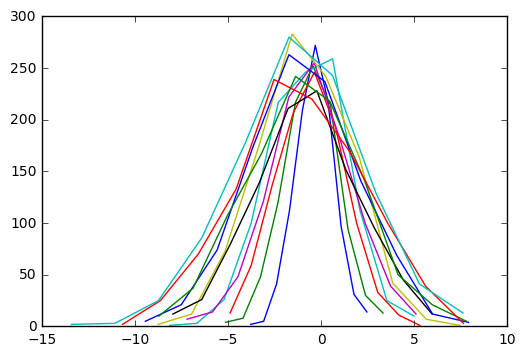

In [790]:
for i in range(len(inputs)):
  y, bins = np.histogram(baysean_monte_carlo_wrong[:,0,0,i])
  plt.plot(bins[:-1], y)
plt.show()

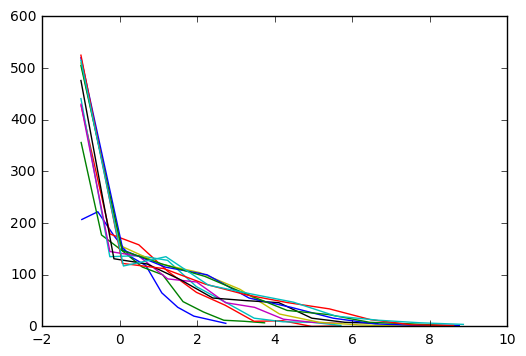

In [791]:
elu_loss_wrong = K.eval(K.elu(K.variable(baysean_monte_carlo_wrong)))
for i in range(len(inputs)):
  y, bins = np.histogram(elu_loss_wrong[:,0,0,i])
  plt.plot(bins[:-1], y)
plt.show()

In [792]:
for i in range(elu_loss_wrong.shape[-1]-1):
  print("mean", np.mean(elu_loss_wrong[:,0,0,i]), "variance", i+1)

mean 0.178115 variance 1
mean 0.231776 variance 2
mean 0.392241 variance 3
mean 0.489651 variance 4
mean 0.591501 variance 5
mean 0.614974 variance 6
mean 0.707893 variance 7
mean 0.733919 variance 8
mean 0.794722 variance 9
mean 0.86684 variance 10


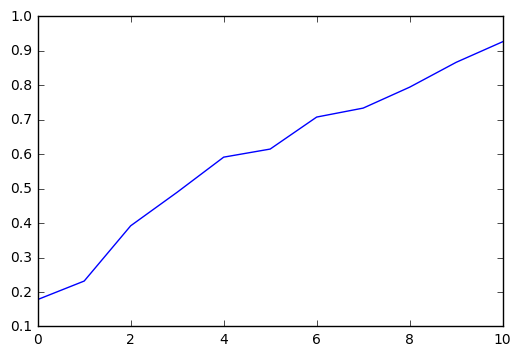

In [793]:
plt.plot(np.mean(elu_loss_wrong[:,0,0], axis=0))
plt.show()

In [761]:
inputs = np.array([[10.0, 0.0, i] for i in range(1, 6)])
true = np.dstack([np.ones(len(inputs)), np.zeros(len(inputs))])
baysean_monte_carlo_right = K.eval(bayesian_categorical_crossentropy_monte_carlo(1000, 2)(K.variable(true), K.variable(inputs)))

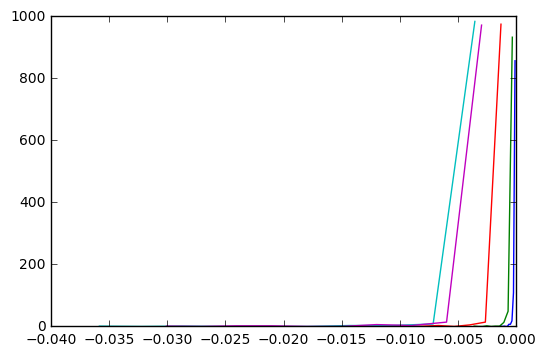

In [762]:
for i in range(len(inputs)):
  y, bins = np.histogram(baysean_monte_carlo_right[:,0,0,i])
  plt.plot(bins[:-1], y)
plt.show()

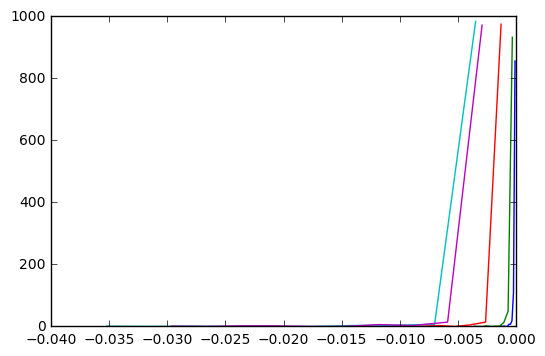

In [763]:
elu_loss_right = K.eval(K.elu(K.variable(baysean_monte_carlo_right)))
for i in range(len(inputs)):
  y, bins = np.histogram(elu_loss_right[:,0,0,i])
  plt.plot(bins[:-1], y)
plt.show()

In [770]:
for i in range(elu_loss_right.shape[-1]):
  print("mean", np.mean(elu_loss_right[:,0,0,i]), "variance", i+1)

mean -3.00885e-05 variance 1
mean -7.02616e-05 variance 2
mean -0.000166848 variance 3
mean -0.000303218 variance 4
mean -0.00039563 variance 5
